<a href="https://colab.research.google.com/github/Willsu00/COMP723-Assignment/blob/main/COMP723_Depression_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import zipfile
zf = zipfile.ZipFile('/content/drive/MyDrive/COMP723Data/Depression Reddit Dataset.zip')
df = pd.read_csv(zf.open('depression_dataset_reddit_cleaned.csv'))

# first 10 rows
display(df.head(10))

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
5,i m year old turning soon in a few month i liv...,1
6,i live alone and despite me being prone to lon...,1
7,i m not looking for sympathy just simply to st...,1
8,i don t know how to communicate all of my thou...,1
9,mom i m sad it hurt in my heart the feeling fa...,1


In [ ]:
!pip install --upgrade keras



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

X = df['clean_text']
y = df['is_depression']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Current depression rate in each set. This is used later for comparing the models to the real resutls
print("Current Training Set Results Before Processing")
print("==============================================\n")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Depression rate in train: {y_train.mean():.3f}")
print(f"Depression rate in test: {y_test.mean():.3f}")

Current Training Set Results Before Processing

Training set size: 6184
Test set size: 1547
Depression rate in train: 0.495
Depression rate in test: 0.496


# Naive Bayes

In [ ]:
def naive_bayes_model(X_train, X_test, y_train, y_test):
    print("=================")
    print("NAIVE BAYES MODEL")
    print("=================")

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train_tfidf, y_train)

    # Predictions
    y_pred = nb_model.predict(X_test_tfidf)
    y_pred_proba = nb_model.predict_proba(X_test_tfidf)[:, 1]

    # Evaluation
    print("Naive Bayes Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance (most indicative words for depression)
    feature_names = vectorizer.get_feature_names_out()
    depression_probs = nb_model.feature_log_prob_[1]  # Class 1 probabilities
    top_features_idx = np.argsort(depression_probs)[-20:][::-1]

    # print("\nTop 20 words associated with depression:")
    # for idx in top_features_idx:
    #     print(f"{feature_names[idx]}: {np.exp(depression_probs[idx]):.4f}")

    return nb_model, vectorizer, y_pred, y_pred_proba

# Run Naive Bayes
nb_model, vectorizer, nb_pred, nb_proba = naive_bayes_model(X_train, X_test, y_train, y_test)

NAIVE BAYES MODEL
Naive Bayes Results:
Accuracy: 0.8966

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       780
           1       0.86      0.95      0.90       767

    accuracy                           0.90      1547
   macro avg       0.90      0.90      0.90      1547
weighted avg       0.90      0.90      0.90      1547



# Neural Network


BASIC NEURAL NETWORK
Basic Neural Network Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8372 - loss: 0.3794 - val_accuracy: 0.9709 - val_loss: 0.1024
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9686 - loss: 0.1114 - val_accuracy: 0.9741 - val_loss: 0.0844
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9808 - loss: 0.0637 - val_accuracy: 0.9748 - val_loss: 0.0810
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9909 - loss: 0.0300 - val_accuracy: 0.9774 - val_loss: 0.0762
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9966 - loss: 0.0143 - val_accuracy: 0.9754 - val_loss: 0.0929
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9787 - val_loss: 0.0986
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9793 - val_loss: 0.0992
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accu

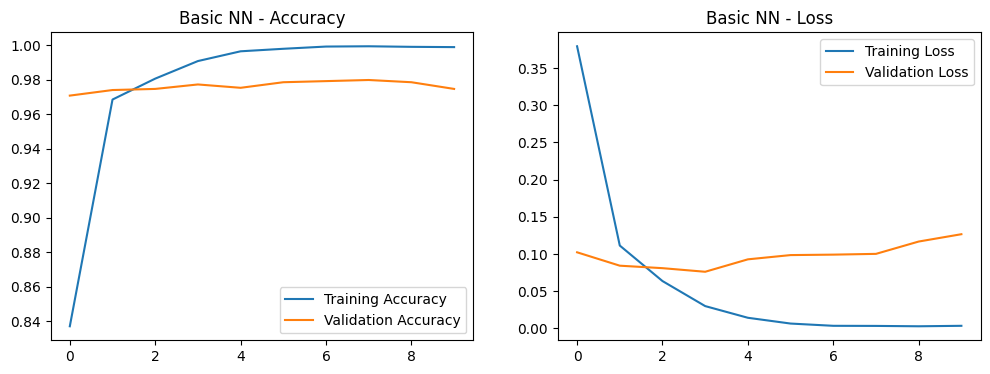

In [ ]:
def basic_neural_network(X_train, X_test, y_train, y_test, vocab_size=10000, max_length=100):
    print("\n" + "=" * 50)
    print("BASIC NEURAL NETWORK")
    print("=" * 50)

    # Tokenization
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # Build Basic Neural Network
    basic_nn_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    basic_nn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Basic Neural Network Architecture:")
    basic_nn_model.summary()

    # Train model
    history = basic_nn_model.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test_pad, y_test),
        verbose=1
    )

    # Predictions
    y_pred_proba = basic_nn_model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Evaluation
    print("\nBasic Neural Network Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Basic NN - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Basic NN - Loss')
    plt.legend()
    plt.show()

    return basic_nn_model, tokenizer, y_pred, y_pred_proba, history

# Run Basic Neural Network
basic_nn, tokenizer, basic_pred, basic_proba, basic_history = basic_neural_network(
    X_train, X_test, y_train, y_test
)

In [ ]:
def simplified_neural_network(X_train, X_test, y_train, y_test, vocab_size=5000, max_length=50):
    print("SIMPLIFIED NEURAL NETWORK (Reduced Overfitting)")

    # Tokenization with smaller vocab
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Shorter sequence length
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # MUCH SIMPLER MODEL
    simple_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),  # Reduced embedding
        GlobalMaxPooling1D(),
        Dense(16, activation='relu'),  # Fewer units
        Dropout(0.6),  # More dropout
        Dense(1, activation='sigmoid')
    ])

    simple_model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Add early stopping
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = simple_model.fit(
        X_train_pad, y_train,
        epochs=20,  # More epochs but with early stopping
        batch_size=32,
        validation_data=(X_test_pad, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluation
    y_pred_proba = simple_model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"Simplified NN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    return simple_model, y_pred, y_pred_proba, history

# Try the simplified version
simple_nn, simple_pred, simple_proba, simple_history = simplified_neural_network(
    X_train, X_test, y_train, y_test
)

SIMPLIFIED NEURAL NETWORK (Reduced Overfitting)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6711 - loss: 0.6349 - val_accuracy: 0.8714 - val_loss: 0.4908
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8960 - loss: 0.3685 - val_accuracy: 0.9444 - val_loss: 0.2148
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9237 - loss: 0.2401 - val_accuracy: 0.9567 - val_loss: 0.1541
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9373 - loss: 0.1979 - val_accuracy: 0.9606 - val_loss: 0.1291
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9495 - loss: 0.1645 - val_accuracy: 0.9644 - val_loss: 0.1136
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9570 - loss: 0.1487 - val_accuracy: 0.9657 - val_loss: 0.1033
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9623 - loss: 0.1320 - val_accuracy: 0.9683 - val_loss: 0.0977
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9688 - loss: 0.1161 - val_accuracy: 0.9709 - val_


REGULARIZED NEURAL NETWORK
Regularized NN Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5385 - loss: 1.0833 - val_accuracy: 0.8171 - val_loss: 1.0459
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5524 - loss: 1.0206 - val_accuracy: 0.8171 - val_loss: 0.9837
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6030 - loss: 0.9607 - val_accuracy: 0.8171 - val_loss: 0.9293
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6287 - loss: 0.9171 - val_accuracy: 0.8171 - val_loss: 0.8841
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6698 - loss: 0.8724 - val_accuracy: 0.8171 - val_loss: 0.8432
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6916 - loss: 0.8388 - val_accuracy: 0.8171 - val_loss: 0.8072
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7130 - loss: 0.8025 - val_accuracy: 0.8171 - val_loss: 0.7723
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7245 - loss: 0.7759 - val_accuracy: 0.

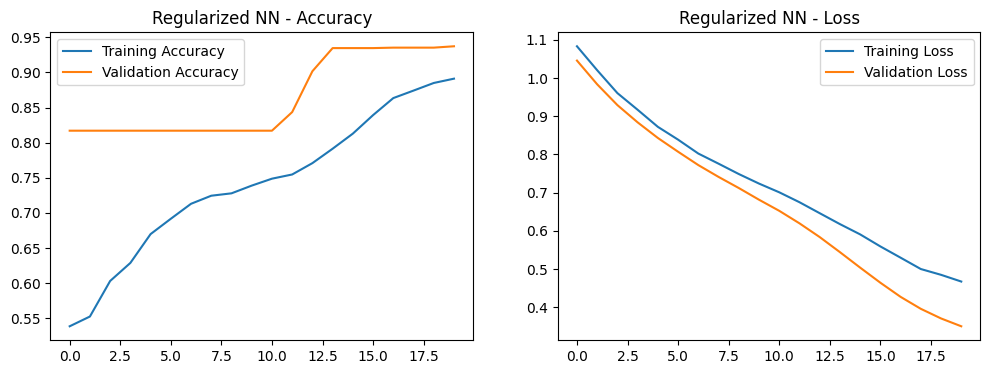

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def regularized_neural_network(X_train, X_test, y_train, y_test, vocab_size=3000, max_length=50):
    print("\n" + "=" * 50)
    print("REGULARIZED NEURAL NETWORK")
    print("=" * 50)

    # Tokenization
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # Build Regularized Model
    model = Sequential([
        Embedding(vocab_size, 16, input_length=max_length),  # Small embeddings
        GlobalMaxPooling1D(),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.7),
        Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.7),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Regularized NN Architecture:")
    model.summary()

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train_pad, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_pad, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    # Predictions
    y_pred_proba = model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Evaluation
    print("\nRegularized Neural Network Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Regularized NN - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Regularized NN - Loss')
    plt.legend()
    plt.show()

    return model, tokenizer, y_pred, y_pred_proba, history

# Run regularized neural network
reg_nn, reg_tokenizer, reg_pred, reg_proba, reg_history = regularized_neural_network(
    X_train, X_test, y_train, y_test
)

In [ ]:
def ultra_simple_nn(X_train, X_test, y_train, y_test, vocab_size=2000, max_length=30):
    print("\n" + "=" * 50)
    print("ULTRA SIMPLE NEURAL NETWORK")
    print("=" * 50)

    # Tokenization
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # Ultra Simple Model
    model = Sequential([
        Embedding(vocab_size, 8, input_length=max_length),  # Very small
        GlobalMaxPooling1D(),
        Dropout(0.8),  # Heavy dropout
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Ultra Simple NN Architecture:")
    model.summary()

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train_pad, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_pad, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    # Predictions
    y_pred_proba = model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print(f"Ultra Simple NN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    return model, tokenizer, y_pred, y_pred_proba, history

# run
simple_nn, simple_tokenizer, simple_pred, simple_proba, simple_history = ultra_simple_nn(
    X_train, X_test, y_train, y_test
)


ULTRA SIMPLE NEURAL NETWORK
Ultra Simple NN Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5707 - loss: 0.6586 - val_accuracy: 0.8849 - val_loss: 0.6060
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6601 - loss: 0.6132 - val_accuracy: 0.8849 - val_loss: 0.5566
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7327 - loss: 0.5848 - val_accuracy: 0.8849 - val_loss: 0.5181
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7561 - loss: 0.5679 - val_accuracy: 0.8849 - val_loss: 0.4888
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7597 - loss: 0.5594 - val_accuracy: 0.8849 - val_loss: 0.4655
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7599 - loss: 0.5460 - val_accuracy: 0.9082 - val_loss: 0.4441
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7628 - loss: 0.5282 - val_accuracy: 0.9670 - val_loss: 0.4226
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7612 - loss: 0.5305 - val_accuracy: 0.

In [ ]:
# Check for data leakage and duplicates
def check_data_issues(X_train, X_test, y_train, y_test):
    print("DATA QUALITY CHECKS")
    print("=" * 40)

    # Check for duplicate comments between train and test
    train_set = set(X_train)
    test_set = set(X_test)
    overlaps = train_set.intersection(test_set)
    print(f"Overlapping comments between train/test: {len(overlaps)}")

    # Check for duplicate comments within training set
    train_duplicates = len(X_train) - len(set(X_train))
    print(f"Duplicate comments in training set: {train_duplicates}")

    # Check comment length distribution
    train_lengths = [len(comment.split()) for comment in X_train]
    test_lengths = [len(comment.split()) for comment in X_test]
    print(f"Avg train comment length: {np.mean(train_lengths):.1f} words")
    print(f"Avg test comment length: {np.mean(test_lengths):.1f} words")

    # Check if very short comments are dominating
    short_comments_train = sum(1 for length in train_lengths if length <= 3)
    short_comments_test = sum(1 for length in test_lengths if length <= 3)
    print(f"Train comments with <= 3 words: {short_comments_train} ({short_comments_train/len(X_train)*100:.1f}%)")
    print(f"Test comments with <= 3 words: {short_comments_test} ({short_comments_test/len(X_test)*100:.1f}%)")

check_data_issues(X_train, X_test, y_train, y_test)

DATA QUALITY CHECKS
Overlapping comments between train/test: 20
Duplicate comments in training set: 54
Avg train comment length: 75.1 words
Avg test comment length: 72.9 words
Train comments with <= 3 words: 161 (2.6%)
Test comments with <= 3 words: 32 (2.1%)


# CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

def cnn_non_preprocessed(X_train, X_test, y_train, y_test, vocab_size=3000, max_length=50):
    print("\n" + "=" * 50)
    print("CNN - NON-PREPROCESSED DATA")
    print("=" * 50)

    # Tokenization (no text cleaning - raw data)
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # CNN Model
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_length),

        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),

        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),

        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("CNN Architecture:")
    model.summary()

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train_pad, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test_pad, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    # Predictions
    y_pred_proba = model.predict(X_test_pad)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Evaluation
    print("\nCNN Results (Non-Preprocessed):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model, tokenizer, y_pred, y_pred_proba, history

# Run CNN on non-preprocessed data
cnn_model, cnn_tokenizer, cnn_pred, cnn_proba, cnn_history = cnn_non_preprocessed(
    X_train, X_test, y_train, y_test
)


CNN - NON-PREPROCESSED DATA
CNN Architecture:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_11         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9070 - loss: 0.2496 - val_accuracy: 0.9638 - val_loss: 0.1288
Epoch 2/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9719 - loss: 0.0948 - val_accuracy: 0.8998 - val_loss: 0.2882
Epoch 3/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9811 - loss: 0.0664 - val_accuracy: 0.9541 - val_loss: 0.1457
Epoch 4/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9866 - loss: 0.0530 - val_accuracy: 0.9690 - val_loss: 0.1095
Epoch 5/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9893 - loss: 0.0431 - val_accuracy: 0.9515 - val_loss: 0.1693
Epoch 6/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9905 - loss: 0.0371 - val_accuracy: 0.9457 - val_loss: 0.1936
Epoch 7/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9935 - loss: 0.0273 - val_accuracy: 0.9451 - val_loss: 0.1925
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
49/49 ━━━━━━━━

# Non-Preprocessed Results Summary:
## Model	Accuracy
Naive Bayes	89%	-> Strong baseline

Neural Network (Regularized)	93%	-> Good improvement

CNN	96.9%	-> Best performer

## Key Observations:
- Excellent Performance: All models show remarkably high accuracy for depression detection

- Consistent Pattern: Each more complex model improves upon the previous one

- CNN Excellence: The CNN architecture is particularly well-suited for this text classification task

- Early Stopping Worked: Training stopped at epoch 7, preventing overfitting (SEEN IN CNN)

# NOTES:

Difference in recall value indicates levels of bias

In terms of reading NN, e.g:

Epoch 1/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9070 - loss: 0.2496 - val_accuracy: 0.9638 - val_loss: 0.1288

accuracy - loss (this is training accuracy), val_accuracy - val_loss (this is testing accuracy)

Gap = accuracy - val_accuracy

Rule of Thumb is that if Gap = -X% then that may indicate some dropout, +X% indicates some overfitting. The acceptable range would be ±1-3%

Underfitting is seen as super low accuracies e.g., 70% - 75% or below

NB guesses if a comment shows depression by counting how often words appear in depressed vs non-depressed comments. It assumes words don't affect each other, which makes it fast but not as smart as NN at understanding language patterns.

---

## Diff in NN and CNN

### Neural Network (NN):
"Reads the whole comment at once and tries to understand the overall meaning"

Looks at all words simultaneously

Good at capturing general sentiment and tone

Like reading a paragraph and getting the main feeling

### CNN (Convolutional Neural Network):
"Scans for specific phrases and patterns that indicate depression"

Looks at word combinations and local patterns

Detects key phrases like "I feel hopeless" or "can't get out of bed"

Like highlighting important sentences that scream "depression"

### Simple Analogy:
NN = Reading the whole comment and judging the overall mood

CNN = Looking for specific "depression keywords" and patterns

Why CNN Works Better for Your Task:
Depression often shows up in specific phrases and word combinations rather than just overall sentiment. The CNN is better at spotting these tell-tale linguistic patterns.

